In [37]:
import pandas as pd
import numpy as np
from pprint import pprint
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

# DATA CLEANING AND VISUALIZATIONS

In [16]:
#read the original dataset
df_clean = pd.read_csv('A2_data.csv')

#drop the features tha are not needed for the predicting task
df_clean = df_clean.drop('field_ID', axis=1) 
df_clean = df_clean.drop('MJD', axis=1) 
df_clean = df_clean.drop('plate', axis=1) 

In [ ]:
# find where the g,u,z is negative
print( df_clean[df_clean['g'] < 0] )
print( df_clean[df_clean['u'] < 0] )
print( df_clean[df_clean['z'] < 0] )

In [17]:
g_column = df_clean['g']
u_column = df_clean['u']
z_column = df_clean['z']

# round up the values in the g,u,z columns
g_column = g_column.round(0)
u_column = u_column.round(0)
z_column = z_column.round(0)

g_column.unique()
u_column.unique()
z_column.unique()

array([   19.,    22.,    16.,    20.,    17.,    18.,    21.,    23.,
          15.,    14.,    12.,    24.,    13.,    25.,    11.,    10.,
          26.,    28.,    29.,    27., -9999.])

In [18]:
# drop row 79543 as it is an extreme outlier
df_clean = df_clean.drop(79543, axis=0)

In [19]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99999 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   alpha     99999 non-null  float64
 1   delta     99999 non-null  float64
 2   u         99999 non-null  float64
 3   g         99999 non-null  float64
 4   r         99999 non-null  float64
 5   i         99999 non-null  float64
 6   z         99999 non-null  float64
 7   redshift  99999 non-null  float64
 8   class     99999 non-null  object 
dtypes: float64(8), object(1)
memory usage: 7.6+ MB


In [20]:
# transform classes to numbers
df_clean['class'] = df_clean['class'].map({'GALAXY': 1, 'QSO': 2, 'STAR': 3})

df_x = df_clean.iloc[:,0:8]
df_y = df_clean['class']

In [21]:
df_x.describe()

,alpha,delta,u,g,r,i,z,redshift
count,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000
mean,177.628653,24.135552,22.080679,20.631583,19.645777,19.084865,18.768988,0.001360
std,96.502612,19.644608,2.251068,2.037384,1.854763,1.757900,1.765982,3.002684
min,0.005528,-18.785328,10.996230,10.498200,9.822070,9.469903,9.612333,-12.160000
25%,127.517698,5.147477,20.352410,18.965240,18.135795,17.732280,17.460830,-2.027000
50%,180.900527,23.646462,22.179140,21.099930,20.125310,19.405150,19.004600,0.012340
75%,233.895005,39.901582,23.687480,22.123775,21.044790,20.396510,19.921120,2.040000
max,359.999810,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,14.160000


In [22]:
#scaling

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_x)

# convert the scaled data to a dataframe
df_x = pd.DataFrame(df_scaled, columns=df_x.columns)

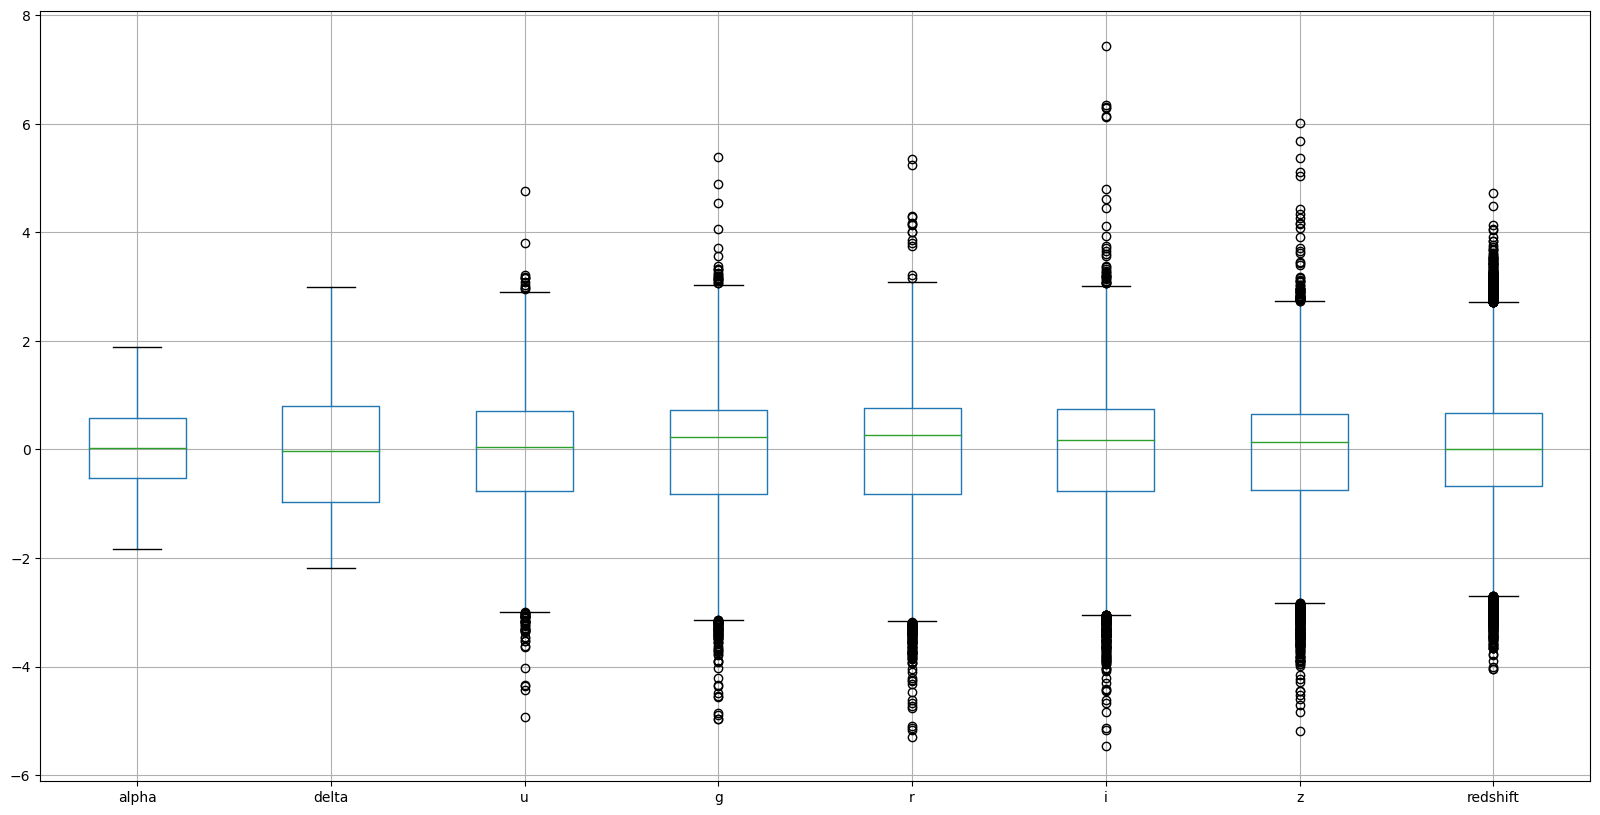

In [23]:
# box plot of the data
df_x.boxplot(figsize=(20,10))
plt.show()

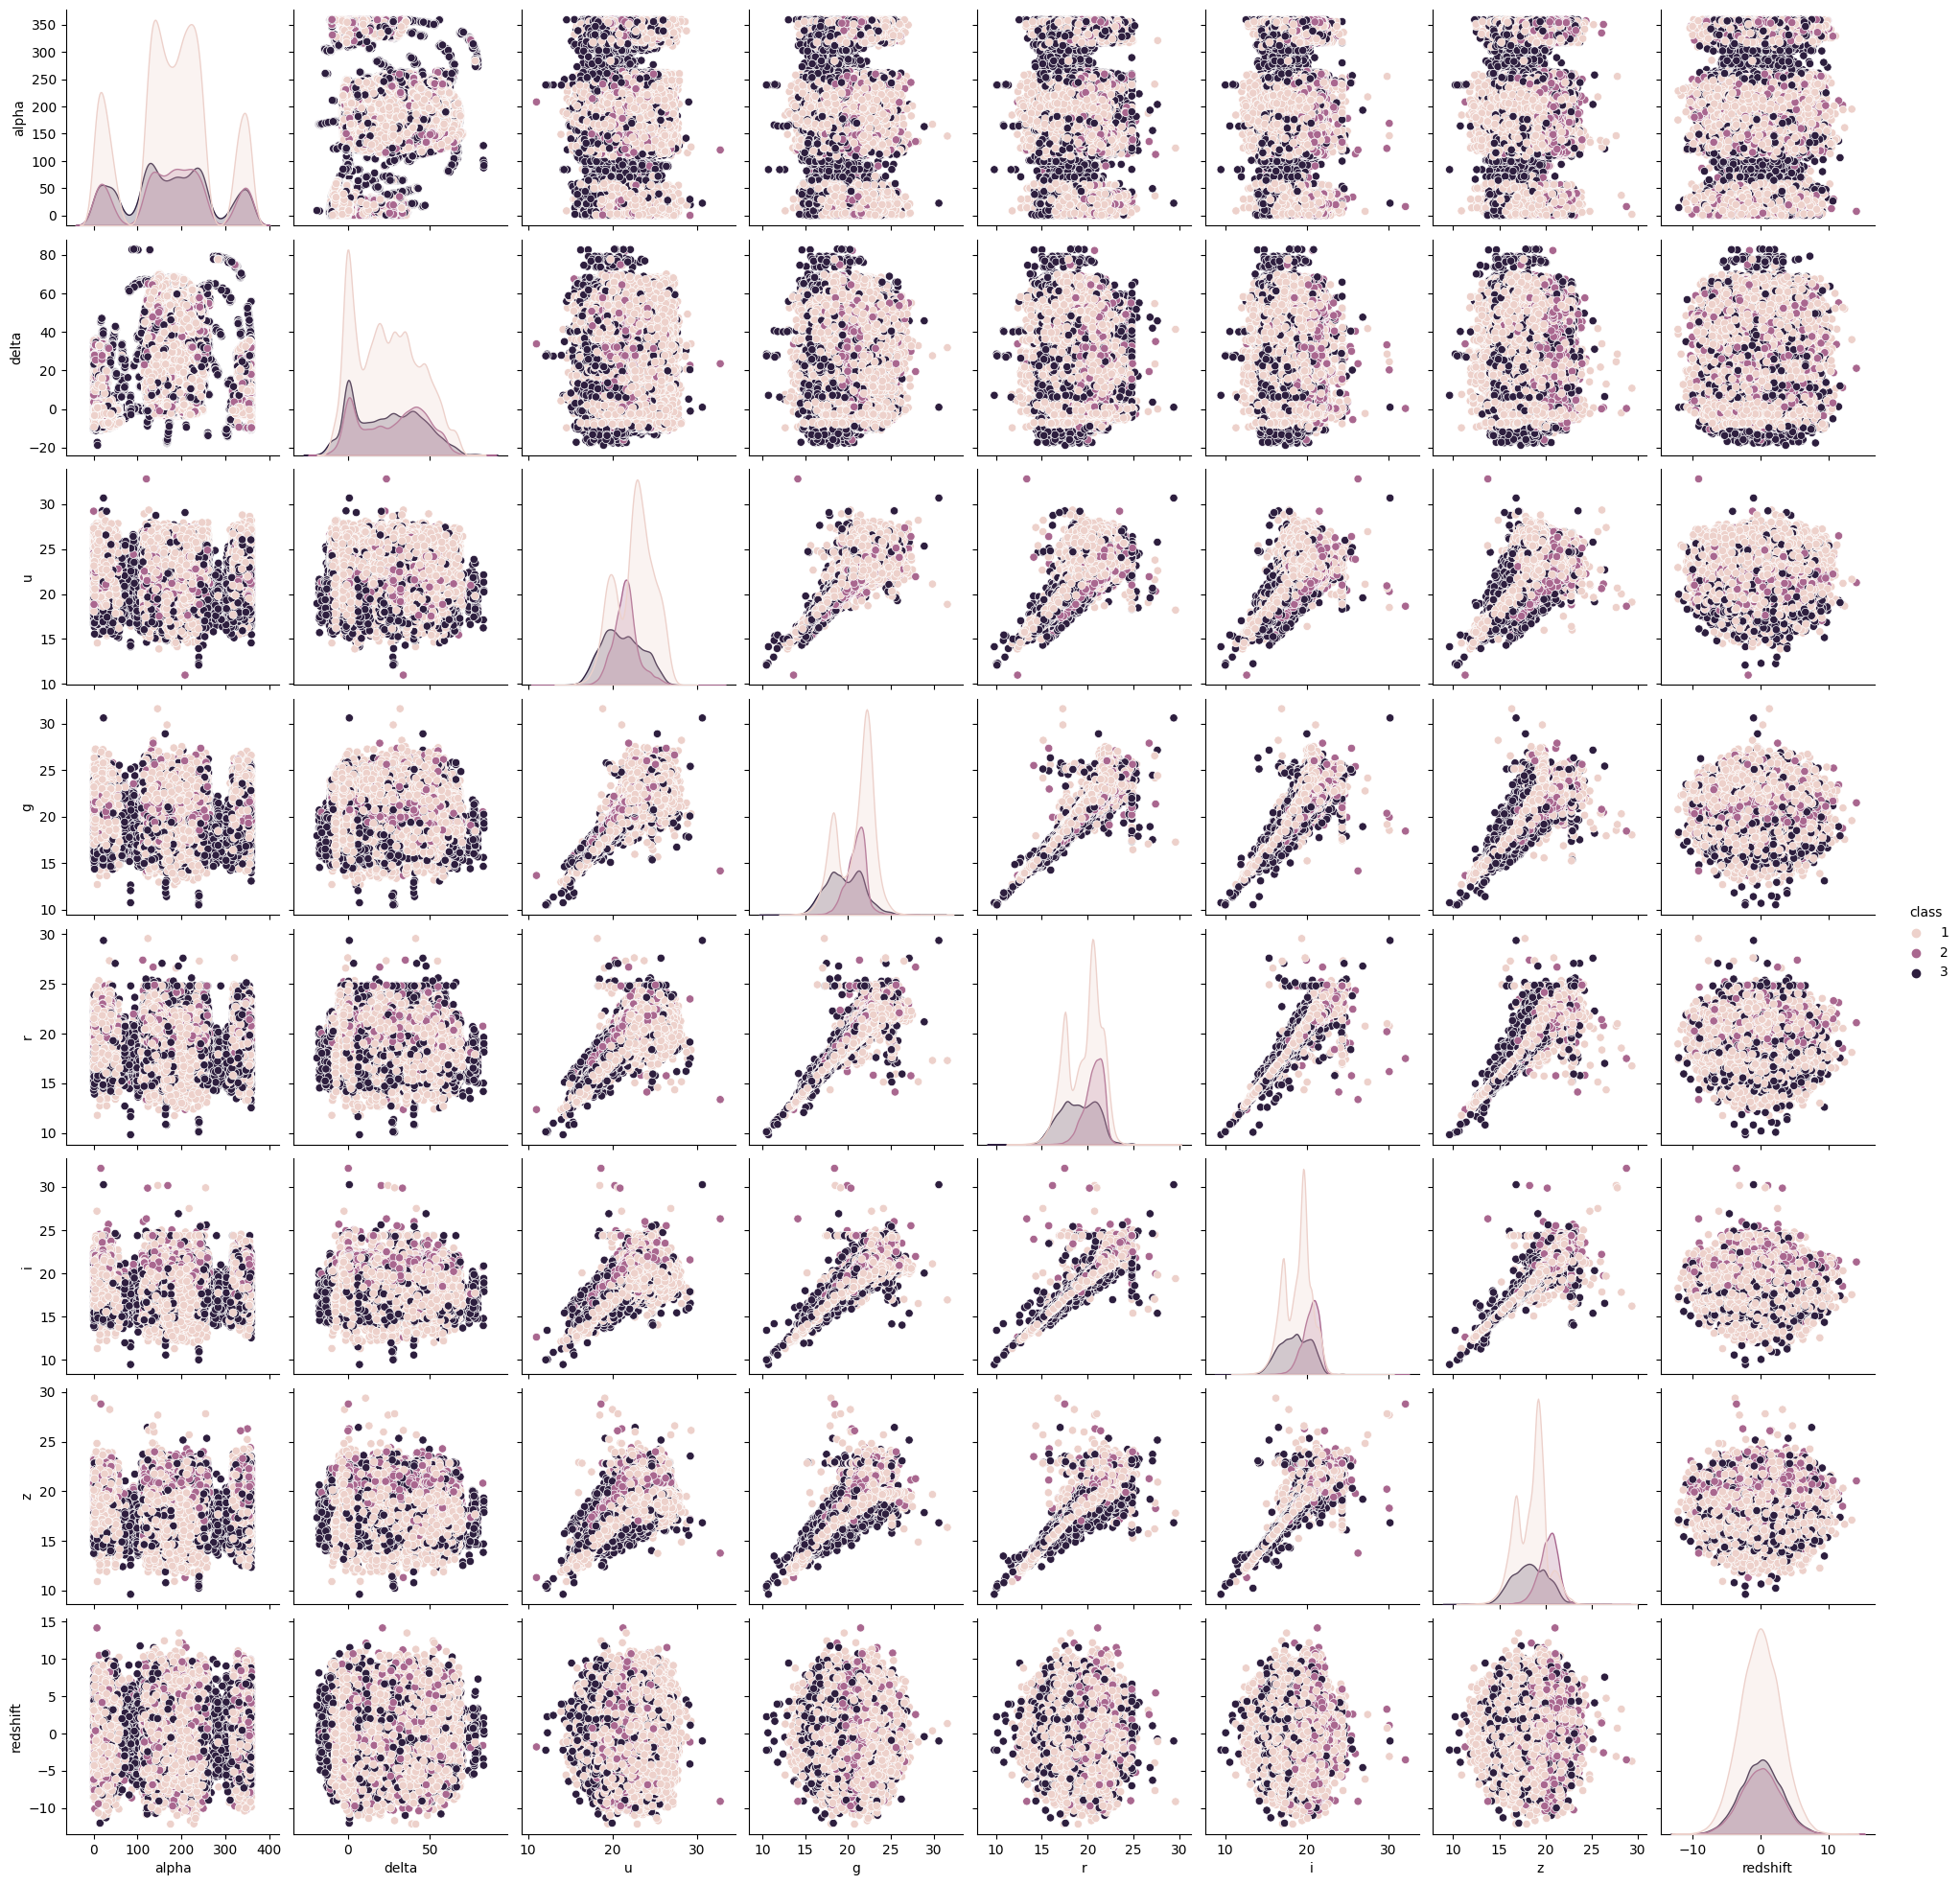

In [24]:
# visualize the data with seaborn pairplot

sns.pairplot(df_clean, hue='class')
plt.show()

             alpha     delta         u         g         r         i  \
alpha     1.000000  0.138698 -0.000222 -0.014118 -0.022079 -0.023577   
delta     0.138698  1.000000 -0.026845 -0.007077 -0.006845 -0.004488   
u        -0.000222 -0.026845  1.000000  0.853350  0.728681  0.618346   
g        -0.014118 -0.007077  0.853350  1.000000  0.932996  0.847046   
r        -0.022079 -0.006845  0.728681  0.932996  1.000000  0.962868   
i        -0.023577 -0.004488  0.618346  0.847046  0.962868  1.000000   
z        -0.025160 -0.006286  0.545760  0.775302  0.919114  0.971546   
redshift -0.001231  0.001705 -0.006827 -0.005258 -0.003897 -0.002688   

                 z  redshift  
alpha    -0.025160 -0.001231  
delta    -0.006286  0.001705  
u         0.545760 -0.006827  
g         0.775302 -0.005258  
r         0.919114 -0.003897  
i         0.971546 -0.002688  
z         1.000000 -0.000693  
redshift -0.000693  1.000000  


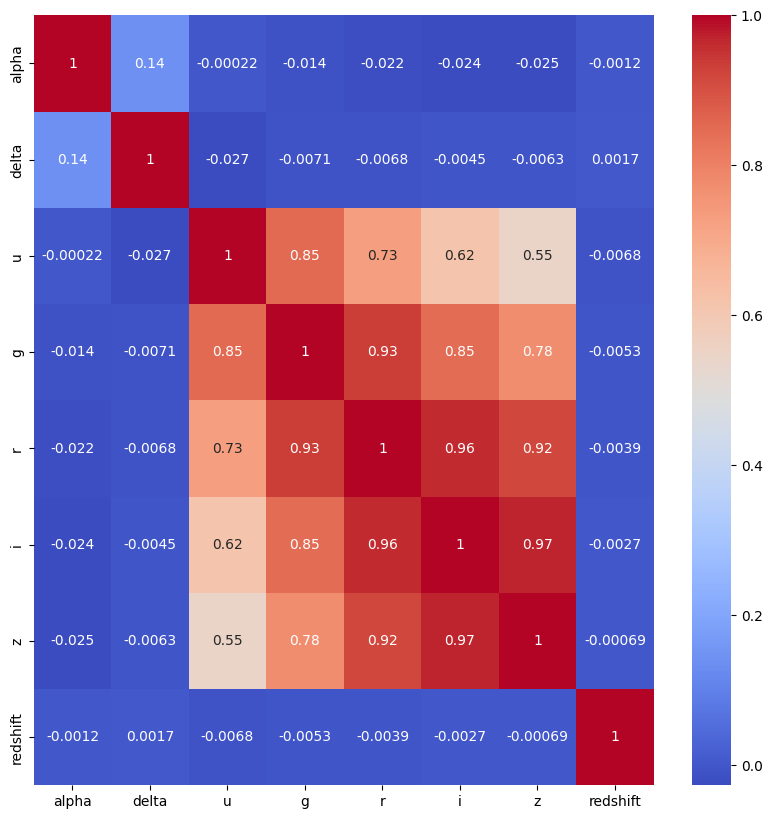

In [25]:
# find the correlation matrix
corr = df_x.corr()
print(corr)

# plot the correlation matrix
plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()


In [26]:
#How they are distributed
featurecols = list(df_x)
astrObjs = df_y.unique()
colours = ['indigo', '#FF69B4', 'cyan']
plt.figure(figsize=(15,10))
for i in range(len(featurecols)):
    plt.subplot(4, 4, i+1)
    for j in range(len(astrObjs)):
        sns.distplot(df_clean[df_clean['class']==astrObjs[j]][featurecols[i]], hist = False, kde = True, color = colours[j], kde_kws = {'shade': True, 'linewidth': 3}, label = astrObjs[j])
    plt.legend()
    plt.title('Density Plot')
    plt.xlabel(featurecols[i])
    plt.ylabel('Density')
plt.tight_layout()

/var/folders/4c/3w812pf10wz4q19tlrr1fc9m0000gn/T/ipykernel_4320/1178259242.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_clean[df_clean['class']==astrObjs[j]][featurecols[i]], hist = False, kde = True, color = colours[j], kde_kws = {'shade': True, 'linewidth': 3}, label = astrObjs[j])
/Users/achris/miniconda3/envs/snacs/lib/python3.10/site-packages/seaborn/distributions.py:2517: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
/var/folders/4c/3w812pf10wz4q19tlr

# DIMENSIONALITY REDUCTION

# PCA

In [29]:
pca = PCA(n_components=2)
pca.fit(df_scaled)
transformed_scaled = pca.transform(df_scaled)

In [30]:
transformed_pca = pd.DataFrame(transformed_scaled, columns=['PC1', 'PC2'])
transformed_pca

,PC1,PC2
0,-0.902578,0.008765
1,-2.981371,0.054978
2,-1.368684,0.173273
3,-1.703697,0.328896
4,3.602040,1.073680
...,...,...
99994,-2.230306,-1.940724
99995,-1.063393,-1.221326
99996,1.557219,0.016833
99997,-0.799520,1.079741


# T-SNE

In [31]:
# apply t-SNE

tsne = TSNE(n_components=2, perplexity=50)
transformed = tsne.fit_transform(df_scaled)

/Users/achris/miniconda3/envs/snacs/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/achris/miniconda3/envs/snacs/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [32]:
transformed_TSNE = pd.DataFrame(transformed, columns=['TSNE1', 'TSNE2'])
transformed_TSNE

,TSNE1,TSNE2
0,9.640200,-21.105434
1,37.707283,-17.927256
2,12.295695,-22.196896
3,-22.665346,-30.153271
4,-38.744850,-0.210036
...,...,...
99994,31.803839,21.817415
99995,11.590601,21.929234
99996,-9.221504,19.090714
99997,2.617938,-41.473274


# UMAP

In [35]:
# Apply UMAP

umap = umap.UMAP(n_components=2)
transformed = umap.fit_transform(df_scaled)

In [36]:
transformed_UMAP = pd.DataFrame(transformed, columns=['UMAP1', 'UMAP2'])
transformed_UMAP

,UMAP1,UMAP2
0,12.396409,12.814098
1,7.512003,16.289433
2,12.111073,13.160452
3,-5.779682,4.629344
4,-2.139803,8.725323
...,...,...
99994,10.385969,-5.232167
99995,13.838698,-3.108667
99996,8.153344,7.468694
99997,13.969075,14.263400


# ADABOOST

ORIGINAL DATA

In [ ]:
#split the dataset
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.3, random_state=123, stratify=df_y)

In [ ]:
clf = AdaBoostClassifier(random_state=123)

HYPERPARAMETER OPTIMIZATION

In [ ]:
parameters = {
    'n_estimators': [5,10,20,30,50,70],
    'learning_rate': [0.1,0.3,0.5,0.8,1],
    'algorithm': ['SAMME', 'SAMME.R']
}
gr_ada = GridSearchCV(clf, parameters, cv=5, verbose=2, n_jobs=-1)
gr_ada.fit(x_train, y_train)

In [ ]:
gr_ada.best_params_

In [ ]:
clf = AdaBoostClassifier(
    algorithm = 'SAMME.R',
    learning_rate = 0.8,
    n_estimators = 70
)
clf.fit(x_train, y_train)

In [ ]:
#Best Parameters

cross_score = cross_val_score(clf,df_x,df_y,cv = 5,scoring = "accuracy")
print(f' Scores for each fold are: {cross_score}')
print(f' Average score: {"{:.2f}".format(cross_score.mean())}')

EXAMINE NUMBER OF ESTIMATORS' IMPACT 

In [ ]:
clf = AdaBoostClassifier(
    algorithm = 'SAMME.R',
    learning_rate = 0.8,
    n_estimators = 1
)
clf.fit(x_train, y_train)

In [ ]:
#Experiment 1 

cross_score = cross_val_score(clf,df_x,df_y,cv = 5,scoring = "accuracy")
print(f' Scores for each fold are: {cross_score}')
print(f' Average score: {"{:.2f}".format(cross_score.mean())}')

In [ ]:
y_pred = clf.predict(x_test)
sortedlabels = clf.classes_

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
print(cm)

In [ ]:
cm = pd.DataFrame(cm, index=sortedlabels, columns=sortedlabels)
sns.set(font_scale=1.2)
sns.heatmap(cm, linewidths=0.5, cmap=sns.light_palette((1, 0.2, 0.6),n_colors=10000), annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')

AFTER PCA

In [ ]:
key=transformed_pca.keys()

In [ ]:
#split the dataset
x_train, x_test, y_train, y_test = train_test_split(transformed_pca, df_y, test_size=0.3, random_state=123, stratify=df_y)

In [ ]:
clf = AdaBoostClassifier(
    algorithm = 'SAMME.R',
    learning_rate = 0.8,
    n_estimators = 70
)
clf.fit(x_train, y_train)

In [ ]:
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
sortedlabels = clf.classes_

In [ ]:
print('features importances are : ' , clf.feature_importances_)

In [ ]:
#Visualize feature importance

plt.figure(figsize=(15,5))
plt.bar(key, clf.feature_importances_)

In [ ]:
y_pred = clf.predict(x_test)
sortedlabels = clf.classes_

Classification Report & Confusion Matrix

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
print(cm)

In [ ]:
cm = pd.DataFrame(cm, index=sortedlabels, columns=sortedlabels)
sns.set(font_scale=1.2)
sns.heatmap(cm, linewidths=0.5, cmap=sns.light_palette((1, 0.2, 0.6),n_colors=10000), annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')

AFTER TSNE

In [ ]:
key=transformed_TSNE.keys()
transformed_TSNE

In [ ]:
#split the dataset
x_train, x_test, y_train, y_test = train_test_split(transformed_TSNE, df_y, test_size=0.3, random_state=123, stratify=df_y)

In [ ]:
clf = AdaBoostClassifier(
    algorithm = 'SAMME.R',
    learning_rate = 0.8,
    n_estimators = 70
)
clf.fit(x_train, y_train)

In [ ]:
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
sortedlabels = clf.classes_

In [ ]:
print('features importances are : ' , clf.feature_importances_)

In [ ]:
#Visualize feature importance

plt.figure(figsize=(15,5))
plt.bar(key,clf.feature_importances_)

In [ ]:
y_pred = clf.predict(x_test)
sortedlabels = clf.classes_

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
print(cm)

In [ ]:
cm = pd.DataFrame(cm, index=sortedlabels, columns=sortedlabels)
sns.set(font_scale=1.2)
sns.heatmap(cm, linewidths=0.5, cmap=sns.light_palette((1, 0.2, 0.6),n_colors=10000), annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')

AFTER UMAP

In [ ]:
key=transformed_UMAP.keys()
transformed_UMAP

In [ ]:
#split the dataset
x_train, x_test, y_train, y_test = train_test_split(transformed_UMAP, df_y, test_size=0.3, random_state=123, stratify=df_y)

In [ ]:
clf = AdaBoostClassifier(
    algorithm = 'SAMME.R',
    learning_rate = 0.8,
    n_estimators = 70
)
clf.fit(x_train, y_train)

In [ ]:
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
sortedlabels = clf.classes_

In [ ]:
print('features importances are : ' , clf.feature_importances_)

In [ ]:
#Visualize feature importance

plt.figure(figsize=(15,5))
plt.bar(key,clf.feature_importances_)

In [ ]:
y_pred = clf.predict(x_test)
sortedlabels = clf.classes_

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
print(cm)

In [ ]:
cm = pd.DataFrame(cm, index=sortedlabels, columns=sortedlabels)
sns.set(font_scale=1.2)
sns.heatmap(cm, linewidths=0.5, cmap=sns.light_palette((1, 0.2, 0.6),n_colors=10000), annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')

# SVM - SVC

FINDING THE KEY PARAMETER

KERNELS

In [3]:
from sklearn.model_selection import KFold


kfold=KFold(n_splits=5, shuffle=True, random_state=0)

SVM WITH POLY

In [23]:
poly_svc=SVC(kernel='poly', decision_function_shape='ovo')


poly_scores = cross_val_score(poly_svc, df_x, df_y, cv=kfold)

print('Stratified cross-validation scores with poly kernel:\n\n{}'.format(poly_scores))

# print average cross-validation score with rbf kernel

print('Average stratified cross-validation score with poly kernel:{:.4f}'.format(poly_scores.mean()))

Stratified cross-validation scores with poly kernel:

[0.681   0.7036  0.68555 0.6779  0.6754 ]
Average stratified cross-validation score with poly kernel:0.6847


SVM WITH RBF

In [24]:
rbf_svc=SVC(kernel='rbf', decision_function_shape='ovo')


rbf_scores = cross_val_score(rbf_svc, df_x, df_y, cv=kfold)

print('Stratified Cross-validation scores with rbf kernel:\n\n{}'.format(rbf_scores))

# print average cross-validation score with rbf kernel

print('Average stratified cross-validation score with rbf kernel:{:.4f}'.format(rbf_scores.mean()))

Stratified Cross-validation scores with rbf kernel:

[0.8049  0.80955 0.8031  0.80235 0.80345]
Average stratified cross-validation score with rbf kernel:0.8047


SVM WITH LINEAR

In [25]:
linear_svc=SVC(kernel='linear', decision_function_shape='ovo')


linear_scores = cross_val_score(linear_svc, df_x, df_y, cv=kfold)

print('Stratified cross-validation scores with linear kernel:\n\n{}'.format(linear_scores))

print('Average stratified cross-validation score with linear kernel:{:.4f}'.format(linear_scores.mean()))

Stratified cross-validation scores with linear kernel:

[0.7533  0.7524  0.7588  0.75185 0.75255]
Average stratified cross-validation score with linear kernel:0.7538


PARAMETER C 

RBF

In [24]:
# instantiate classifier with rbf kernel and C=1
svcRBF1=SVC(kernel = "rbf", C=1.0, decision_function_shape='ovo') 


RBF_scores = cross_val_score(svcRBF1, df_x, df_y, cv=kfold)

print('Stratified cross-validation scores with rbf kernel:\n\n{}'.format(RBF_scores))

print('Average stratified cross-validation score with rbf kernel:{:.4f}'.format(RBF_scores.mean()))

Stratified cross-validation scores with rbf kernel:

[0.85505    0.85475    0.8515     0.8525     0.85314266]
Average stratified cross-validation score with rbf kernel:0.8534


In [25]:
# instantiate classifier with rbf kernel and C=100
svcRBF100=SVC(kernel = "rbf", C=100.0, decision_function_shape='ovo') 


RBF_scores = cross_val_score(svcRBF100, df_x, df_y, cv=kfold)

print('Stratified cross-validation scores with rbf kernel:\n\n{}'.format(RBF_scores))

print('Average stratified cross-validation score with rbf kernel:{:.4f}'.format(RBF_scores.mean()))

Stratified cross-validation scores with rbf kernel:

[0.8747     0.87545    0.8738     0.876      0.87339367]
Average stratified cross-validation score with rbf kernel:0.8747


LINEAR

In [4]:
linear_svc1=SVC(kernel='linear', C=1.0, decision_function_shape='ovo') 


linear_scores = cross_val_score(linear_svc1, df_x, df_y, cv=kfold)

print('Stratified cross-validation scores with linear kernel:\n\n{}'.format(linear_scores))

print('Average stratified cross-validation score with linear kernel:{:.4f}'.format(linear_scores.mean()))

Stratified cross-validation scores with linear kernel:

[0.76985   0.76885   0.7716    0.77125   0.7700885]
Average stratified cross-validation score with linear kernel:0.7703


In [5]:
linear_svc100=SVC(kernel='linear', C=100.0, decision_function_shape='ovo') 


linear_scores = cross_val_score(linear_svc100, df_x, df_y, cv=kfold)

print('Stratified cross-validation scores with linear kernel:\n\n{}'.format(linear_scores))

print('Average stratified cross-validation score with linear kernel:{:.4f}'.format(linear_scores.mean()))

Stratified cross-validation scores with linear kernel:

[0.76995    0.76885    0.77175    0.77115    0.77023851]
Average stratified cross-validation score with linear kernel:0.7704


PARAMETER GAMMA

In [6]:
svc01=SVC(kernel = "rbf", gamma=0.1, decision_function_shape='ovo') 


rbf_scores = cross_val_score(svc01, df_x, df_y, cv=kfold)

print('Stratified cross-validation scores with rbf kernel:\n\n{}'.format(rbf_scores))

print('Average stratified cross-validation score with rbf kernel:{:.4f}'.format(rbf_scores.mean()))

Stratified cross-validation scores with rbf kernel:

[0.8535     0.85235    0.84895    0.8498     0.85154258]
Average stratified cross-validation score with rbf kernel:0.8512


In [7]:
svc02=SVC(kernel = "rbf", gamma=0.2, decision_function_shape='ovo') 


rbf_scores = cross_val_score(svc02, df_x, df_y, cv=kfold)

print('Stratified cross-validation scores with rbf kernel:\n\n{}'.format(rbf_scores))

print('Average stratified cross-validation score with rbf kernel:{:.4f}'.format(rbf_scores.mean()))

Stratified cross-validation scores with rbf kernel:

[0.85985    0.85885    0.85575    0.85805    0.85859293]
Average stratified cross-validation score with rbf kernel:0.8582


In [8]:
svc04=SVC(kernel = "rbf", gamma=0.4, decision_function_shape='ovo') 


rbf_scores = cross_val_score(svc04, df_x, df_y, cv=kfold)

print('Stratified cross-validation scores with rbf kernel:\n\n{}'.format(rbf_scores))

print('Average stratified cross-validation score with rbf kernel:{:.4f}'.format(rbf_scores.mean()))

Stratified cross-validation scores with rbf kernel:

[0.86315    0.8627     0.85815    0.8608     0.86044302]
Average stratified cross-validation score with rbf kernel:0.8610


In [9]:
svc06=SVC(kernel = "rbf", gamma=0.6, decision_function_shape='ovo') 


rbf_scores = cross_val_score(svc06, df_x, df_y, cv=kfold)

print('Stratified cross-validation scores with rbf kernel:\n\n{}'.format(rbf_scores))

print('Average stratified cross-validation score with rbf kernel:{:.4f}'.format(rbf_scores.mean()))

Stratified cross-validation scores with rbf kernel:

[0.8629     0.8623     0.8591     0.8608     0.86089304]
Average stratified cross-validation score with rbf kernel:0.8612


In [10]:
svc08=SVC(kernel = "rbf", gamma=0.8, decision_function_shape='ovo') 


rbf_scores = cross_val_score(svc08, df_x, df_y, cv=kfold)

print('Stratified cross-validation scores with rbf kernel:\n\n{}'.format(rbf_scores))

print('Average stratified cross-validation score with rbf kernel:{:.4f}'.format(rbf_scores.mean()))

Stratified cross-validation scores with rbf kernel:

[0.863      0.86195    0.85935    0.85995    0.86099305]
Average stratified cross-validation score with rbf kernel:0.8610


RANDOM SEARCH FOR HYPARAMETER OPTIMIZATION

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size = 0.2, random_state = 0)

In [4]:
from sklearn.model_selection import RandomizedSearchCV


svc=SVC()

#tuning using Random Search
hyperparameters = [ {'C':[100, 1000], 'kernel':['linear']},
                {'C':[100, 1000], 'kernel':['rbf'], 'gamma':[0.1, 0.4, 0.8]},
                {'C':[100, 1000], 'kernel':['poly'], 'degree': [2,3,4] ,'gamma':[0.01, 0.02, 0.05]} 
               ]


rf_random = RandomizedSearchCV(svc, hyperparameters, n_iter = 10, cv = 5, verbose=2, random_state=123, n_jobs = -1)
rf_random.fit(X_train, y_train)

rf_random.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ......................C=1000, gamma=0.1, kernel=rbf; total time=18.4min
[CV] END ......................C=1000, gamma=0.1, kernel=rbf; total time=18.4min
[CV] END ......................C=1000, gamma=0.1, kernel=rbf; total time=18.6min
[CV] END ..........C=1000, degree=3, gamma=0.05, kernel=poly; total time=19.9min
[CV] END ..........C=1000, degree=3, gamma=0.05, kernel=poly; total time=21.4min
[CV] END ..........C=1000, degree=3, gamma=0.05, kernel=poly; total time=21.9min
[CV] END ..........C=1000, degree=3, gamma=0.05, kernel=poly; total time=23.0min
[CV] END ..........C=1000, degree=3, gamma=0.05, kernel=poly; total time=23.0min
[CV] END ...........C=100, degree=2, gamma=0.01, kernel=poly; total time= 1.8min
[CV] END ...........C=100, degree=2, gamma=0.01, kernel=poly; total time= 2.0min
[CV] END ...........C=100, degree=2, gamma=0.01, kernel=poly; total time= 1.9min
[CV] END ...........C=100, degree=2, gamma=0.01,

{'kernel': 'rbf', 'gamma': 0.1, 'C': 1000}

OVO VS OVR

In [21]:
svc=SVC(kernel = "rbf", C=1000.0, gamma=0.1, decision_function_shape='ovo') 


# fit classifier to training set
svc.fit(X_train,y_train)


# make predictions on test set
y_pred=svc.predict(X_test)


# compute and print accuracy score
print('Model accuracy score with rbf kernel, C=1000.0 and gamma=0.1 - OVO : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with rbf kernel, C=1000.0 and gamma=0.1 - OVO : 0.8773


In [16]:
svc2=SVC(kernel = "rbf", C=1000.0, gamma=0.1, decision_function_shape='ovr') 


# fit classifier to training set
svc2.fit(X_train,y_train)


# make predictions on test set
y_pred_2=svc2.predict(X_test)


# compute and print accuracy score
print('Model accuracy score with rbf kernel, C=1000.0 and gamma=0.1 - OVR : {0:0.4f}'. format(accuracy_score(y_test, y_pred_2)))

Model accuracy score with rbf kernel, C=1000.0 and gamma=0.1 - OVR : 0.8773


CONFUSION MATRIX - SVC(kernel='rbf', gamma=0.1, C=1000.0, decision_function_shape='ovr')

Text(50.722222222222214, 0.5, 'True')

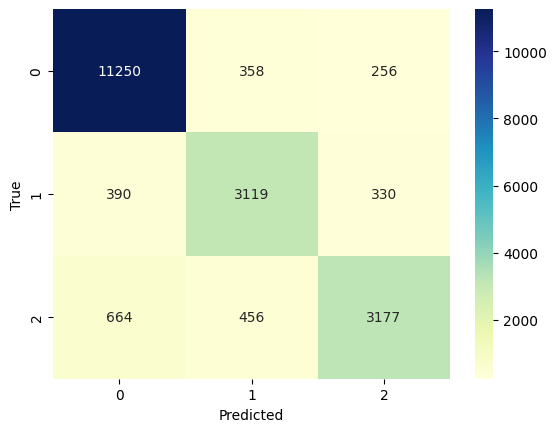

In [17]:
cm = confusion_matrix(y_test, y_pred_2)

cm_matrix = pd.DataFrame(data=cm)

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel('Predicted')
plt.ylabel('True')

CLASSIFICATION REPORT - SVC(kernel='rbf', gamma=0.1, C=1000.0, decision_function_shape='ovr')

In [8]:
print(classification_report(y_test, y_pred_2))

              precision    recall  f1-score   support

           1       0.91      0.95      0.93     11864
           2       0.79      0.81      0.80      3839
           3       0.84      0.74      0.79      4297

    accuracy                           0.88     20000
   macro avg       0.85      0.83      0.84     20000
weighted avg       0.88      0.88      0.88     20000



REDUCED DATA

PCA

In [11]:
from sklearn.decomposition import PCA


pca = PCA(n_components=2)
pca.fit(df_x)
transformed_scaled = pca.transform(df_x)


transformed_pca = pd.DataFrame(transformed_scaled, columns=['PC1', 'PC2'])
transformed_pca

,PC1,PC2
0,-0.902578,0.008765
1,-2.981371,0.054978
2,-1.368684,0.173273
3,-1.703697,0.328896
4,3.602040,1.073680
...,...,...
99994,-2.230306,-1.940724
99995,-1.063393,-1.221326
99996,1.557219,0.016833
99997,-0.799520,1.079741


In [12]:
X_trainPCA, X_testPCA, y_trainPCA, y_testPCA = train_test_split(transformed_pca, df_y, test_size = 0.2, random_state = 0)

In [11]:
X_trainPCA.iloc[:,0]

10382   -0.053771
73171   -0.303468
30938    0.130101
99310    0.057507
58959   -0.326227
           ...   
21243   -0.074075
45891    0.322635
42613    0.329447
43567    0.299846
68268   -0.191566
Name: PC1, Length: 80000, dtype: float64

In [13]:
svcPCA=SVC(kernel = "rbf", C=1000.0, gamma=0.1, decision_function_shape='ovr') 


# fit classifier to training set
svcPCA.fit(X_trainPCA,y_trainPCA)


# make predictions on test set
y_pred_PCA=svcPCA.predict(X_testPCA)


# compute and print accuracy score
print('Model accuracy score with rbf kernel, C=1000.0 and gamma=0.1 - OVR : {0:0.4f}'. format(accuracy_score(y_testPCA, y_pred_PCA)))

Model accuracy score with rbf kernel, C=1000.0 and gamma=0.1 - OVR : 0.5980


TSNE

In [8]:
from sklearn.manifold import TSNE
from sklearn import preprocessing

tsne = TSNE(n_components=2, perplexity=50)
transformed = tsne.fit_transform(df_x)

transformed_TSNE = pd.DataFrame(transformed, columns=['TSNE1', 'TSNE2'])
transformed_TSNE = preprocessing.scale(transformed_TSNE)

/Users/achris/miniconda3/envs/snacs/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/achris/miniconda3/envs/snacs/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/achris/miniconda3/envs/snacs/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:239: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/achris/miniconda3/envs/snacs/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:258: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


In [9]:
X_trainTSNE, X_testTSNE, y_trainTSNE, y_testTSNE = train_test_split(transformed_TSNE, df_y, test_size = 0.2, random_state = 0)

In [10]:
svcTSNE=SVC(kernel = "rbf", C=1000.0, gamma=0.1, decision_function_shape='ovr') 


# fit classifier to training set
svcTSNE.fit(X_trainTSNE,y_trainTSNE)


# make predictions on test set
y_pred_TSNE=svcTSNE.predict(X_testTSNE)


# compute and print accuracy score
print('Model accuracy score with rbf kernel, C=1000.0 and gamma=0.1 - OVR : {0:0.4f}'. format(accuracy_score(y_testTSNE, y_pred_TSNE)))

Model accuracy score with rbf kernel, C=1000.0 and gamma=0.1 - OVR : 0.6993


UMAP

In [5]:
import umap

umap = umap.UMAP(n_components=2)
transformed = umap.fit_transform(df_x)


transformed_UMAP = pd.DataFrame(transformed, columns=['UMAP1', 'UMAP2'])
transformed_UMAP
transformed_UMAP = preprocessing.scale(transformed_UMAP)

/Users/achris/miniconda3/envs/snacs/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/achris/miniconda3/envs/snacs/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:239: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/achris/miniconda3/envs/snacs/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:258: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


In [6]:
X_trainUMAP, X_testUMAP, y_trainUMAP, y_testUMAP = train_test_split(transformed_UMAP, df_y, test_size = 0.2, random_state = 0)

In [7]:
svcUMAP=SVC(kernel = "rbf", C=1000.0, gamma=0.1, decision_function_shape='ovr') 


# fit classifier to training set
svcUMAP.fit(X_trainUMAP,y_trainUMAP)


# make predictions on test set
y_pred_UMAP=svcUMAP.predict(X_testUMAP)


# compute and print accuracy score
print('Model accuracy score with rbf kernel, C=1000.0 and gamma=0.1 - OVR : {0:0.4f}'. format(accuracy_score(y_testUMAP, y_pred_UMAP)))

Model accuracy score with rbf kernel, C=1000.0 and gamma=0.1 - OVR : 0.7255


In [19]:
import warnings
from matplotlib.colors import ListedColormap

def versiontuple(v):
    return tuple(map(int, (v.split("."))))

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o')
    colors = ('red', 'blue', 'lightgreen')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)

    # highlight test samples
    if test_idx:
        # plot all samples
        if not versiontuple(np.__version__) >= versiontuple('1.9.0'):
            X_test, y_test = X[list(test_idx), :], y[list(test_idx)]
            warnings.warn('Please update to NumPy 1.9.0 or newer')
        else:
            X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    alpha=1.0,
                    linewidths=1,
                    marker='o',
                    s=55, label='test set')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


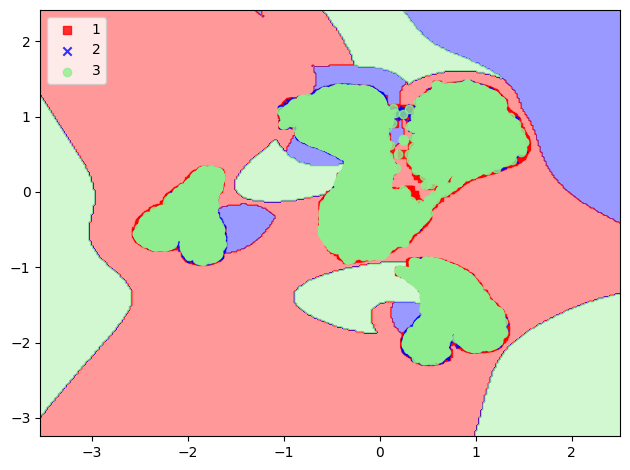

In [20]:
# Visualize the decision boundaries
plot_decision_regions(transformed_UMAP, df_y, classifier=svcUMAP)
plt.legend(loc='upper left')
plt.tight_layout()
plt.title('Decision Boundary - SVM (UMAP reduced data)')
plt.show()

# DECISION TREE - RANDOM FOREST

In [ ]:
#split the dataset
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.3, random_state=123, stratify=df_y)
clf = RandomForestClassifier()

In [ ]:
#Parameters of RandomForest
pprint(clf.get_params())

In [ ]:
#tuning using Random Search
hyperparameters = {'max_features':[None, 'auto', 'sqrt', 'log2'],
                   'max_depth':[None, 1, 5, 10, 15, 20],
                   'min_samples_leaf': [1, 2, 4],
                   'min_samples_split': [2, 5, 10],
                   'n_estimators': [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)],
                   'criterion': ['gini', 'entropy']}
rf_random = RandomizedSearchCV(clf, hyperparameters, n_iter = 100, cv = 5, verbose=2, random_state=123, n_jobs = -1)
rf_random.fit(x_train, y_train)

In [ ]:
rf_random.best_params_

Training the RandomForest

In [ ]:
clf.set_params(criterion = 'entropy', max_features = None, max_depth = None, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 80)

Cross Validation Score

In [ ]:
#Best Parameters
from sklearn.model_selection import cross_val_score

cross_score = cross_val_score(clf,df_x,df_y,cv = 5,scoring = "accuracy")
print(f' Scores for each fold are: {cross_score}')
print(f' Average score: {"{:.2f}".format(cross_score.mean())}')

In [ ]:
#Experiment 1
clf.set_params(criterion = 'entropy', max_features = None, max_depth = 14, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 1)

cross_score = cross_val_score(clf,df_x,df_y,cv = 5,scoring = "accuracy")
print(f' Scores for each fold are: {cross_score}')
print(f' Average score: {"{:.2f}".format(cross_score.mean())}')

In [ ]:
#Experiment 2
clf.set_params(criterion = 'entropy', max_features = None, max_depth = None, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 50)

cross_score = cross_val_score(clf,df_x,df_y,cv = 5,scoring = "accuracy")
print(f' Scores for each fold are: {cross_score}')
print(f' Average score: {"{:.2f}".format(cross_score.mean())}')

TEST AND EVALUATION

In [ ]:
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
sortedlabels = clf.classes_

In [ ]:
print('features importances are : ' , clf.feature_importances_)

In [ ]:
#Visualize feature importance
key=df_x.keys()
plt.figure(figsize=(15,5))
plt.bar(key,clf.feature_importances_)

Classification report and confusion matrix

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
print(cm)

In [ ]:
cm = pd.DataFrame(cm, index=sortedlabels, columns=sortedlabels)
sns.set(font_scale=1.2)
sns.heatmap(cm, linewidths=0.5, cmap=sns.light_palette((1, 0.2, 0.6),n_colors=10000), annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')

AFTER PCA

In [ ]:
#split the dataset
x_train, x_test, y_train, y_test = train_test_split(transformed_pca, df_y, test_size=0.3, random_state=123, stratify=df_y)
clf = RandomForestClassifier()

In [ ]:
#tuning using Random Search
hyperparameters = {'max_features':[None, 'auto', 'sqrt', 'log2'],
                   'max_depth':[None, 1, 5, 10, 15, 20],
                   'min_samples_leaf': [1, 2, 4],
                   'min_samples_split': [2, 5, 10],
                   'n_estimators': [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)],
                   'criterion': ['gini', 'entropy']}
rf_random = RandomizedSearchCV(clf, hyperparameters, n_iter = 50, cv = 5, verbose=2, random_state=123, n_jobs = -1)
rf_random.fit(x_train, y_train)

In [ ]:
rf_random.best_params_

In [ ]:
clf.set_params(criterion = 'entropy', max_features = 'auto', max_depth = 15, min_samples_leaf = 2, min_samples_split = 10, n_estimators = 70)

In [ ]:
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
sortedlabels = clf.classes_

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
print(cm)

In [ ]:
cm = pd.DataFrame(cm, index=sortedlabels, columns=sortedlabels)
sns.set(font_scale=1.2)
sns.heatmap(cm, linewidths=0.5, cmap=sns.light_palette((1, 0.2, 0.6),n_colors=10000), annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')

AFTER TSNE

In [ ]:
#split the dataset
x_train, x_test, y_train, y_test = train_test_split(transformed_TSNE, df_y, test_size=0.3, random_state=123, stratify=df_y)
clf = RandomForestClassifier()

In [ ]:
#tuning using Random Search
hyperparameters = {'max_features':[None, 'auto', 'sqrt', 'log2'],
                   'max_depth':[None, 1, 5, 10, 15, 20],
                   'min_samples_leaf': [1, 2, 4],
                   'min_samples_split': [2, 5, 10],
                   'n_estimators': [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)],
                   'criterion': ['gini', 'entropy']}
rf_random = RandomizedSearchCV(clf, hyperparameters, n_iter = 50, cv = 5, verbose=2, random_state=123, n_jobs = -1)
rf_random.fit(x_train, y_train)

In [ ]:
rf_random.best_params_

In [ ]:
clf.set_params(criterion = 'entropy', max_features = None, max_depth = None, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 80)

In [ ]:
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
sortedlabels = clf.classes_

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
print(cm)

In [ ]:
cm = pd.DataFrame(cm, index=sortedlabels, columns=sortedlabels)
sns.set(font_scale=1.2)
sns.heatmap(cm, linewidths=0.5, cmap=sns.light_palette((1, 0.2, 0.6),n_colors=10000), annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')

AFTER UMAP

In [ ]:
#split the dataset
x_train, x_test, y_train, y_test = train_test_split(transformed_UMAP, df_y, test_size=0.3, random_state=123, stratify=df_y)
clf = RandomForestClassifier()

In [ ]:
hyperparameters = {'max_features':[None, 'auto', 'sqrt', 'log2'],
                   'max_depth':[None, 1, 5, 10, 15, 20],
                   'min_samples_leaf': [1, 2, 4],
                   'min_samples_split': [2, 5, 10],
                   'n_estimators': [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)],
                   'criterion': ['gini', 'entropy']}
rf_random = RandomizedSearchCV(clf, hyperparameters, n_iter = 50, cv = 5, verbose=2, random_state=123, n_jobs = -1)
rf_random.fit(x_train, y_train)


In [ ]:
rf_random.best_params_

In [ ]:
clf.set_params(criterion = 'entropy', max_features = None, max_depth = None, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 80)

In [ ]:
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
sortedlabels = clf.classes_

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
print(cm)

In [ ]:
cm = pd.DataFrame(cm, index=sortedlabels, columns=sortedlabels)
sns.set(font_scale=1.2)
sns.heatmap(cm, linewidths=0.5, cmap=sns.light_palette((1, 0.2, 0.6),n_colors=10000), annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')